In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import plotly.express as px
import json

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Load the processed data

In [3]:
df = pd.read_csv('./data/sea_processed_04-18-2022.csv')
df.drop(columns={'pool', 'dishwasher', 'car_charging', 'income_restrictions', 'elevator'}, inplace=True)
df.head()

,rent,sqft,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,roof,concierge,garage,dist_seattle,dist_transit,cluster_rent_per_sqft,beds_times_baths,pets_allowed
0,6.522093,5.087596,0,0,1,0,0,0,0,3.932519,0.122959,3.829163,0.5,1
1,6.469250,4.997212,0,0,0,1,0,0,0,0.605872,0.075464,3.351396,0.0,0
2,6.469250,4.983607,0,0,0,1,0,0,0,0.605872,0.075464,3.351396,0.0,0
3,6.469250,4.744932,0,0,0,1,0,0,0,0.605872,0.075464,3.351396,0.0,0
4,6.802395,5.159055,0,0,0,1,0,0,0,4.353582,0.076268,3.716994,0.0,0


In [4]:
df = df[df.rent < np.log(8000)]
df.fillna(0,inplace=True)

X = df.drop(['rent'], axis = 1)
y = df['rent']

In [5]:
# split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
X.columns

Index(['sqft', 'fitness_center', 'air_conditioning', 'in_unit_washer_dryer',
       'laundry_facilities', 'roof', 'concierge', 'garage', 'dist_seattle',
       'dist_transit', 'cluster_rent_per_sqft', 'beds_times_baths',
       'pets_allowed'],
      dtype='object')

# 1. Base Model
Construct a linear regression model that only considers rent, number of beds*baths, and distance to seattle as the features. The result from this model will be our base model to compare against every other model that is built. 

In [7]:
# Fit the model 
def regression(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Print results
    print('R squared training set', round(model.score(X_train, y_train)*100, 2))
    print('R squared test set', round(model.score(X_test, y_test)*100, 2))

    # Training data
    pred_train = model.predict(X_train)
    mse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train)))
    mae_train = mean_absolute_error(np.exp(y_train), np.exp(pred_train))
    print('RMSE training set', round(mse_train, 2))
    print('MAE training set', round(mae_train, 2))

    # Test data
    pred_test = model.predict(X_test)
    mse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test)))
    mae_test = mean_absolute_error(np.exp(y_test), np.exp(pred_test))
    print('RMSE test set', round(mse_test, 2))
    print('MAE test set', round(mae_test, 2))
    return model
    
X_base_train = np.array(X_train[['sqft', 'beds_times_baths', 'dist_seattle']])
X_base_test = np.array(X_test[['sqft', 'beds_times_baths', 'dist_seattle']])

In [8]:
model = regression(X_base_train, y_train, X_base_test, y_test)

R squared training set 68.3
R squared test set 67.14
RMSE training set 505.61
MAE training set 369.48
RMSE test set 501.91
MAE test set 370.59


# 2. Linear Regression

In [9]:
model = regression(X_train, y_train, X_test, y_test)

R squared training set 79.25
R squared test set 78.5
RMSE training set 409.15
MAE training set 285.59
RMSE test set 404.64
MAE test set 282.14


# 2a. Lasso Regression

In [10]:
def lasso_regression(X_train, y_train, X_test, y_test):
    lasso = Lasso(alpha=0.0001)
    lasso.fit(X_train, y_train)

    # Print results
    print('R squared training set', round(lasso.score(X_train, y_train)*100, 2))
    print('R squared test set', round(lasso.score(X_test, y_test)*100, 2))

    # Training data
    pred_train = lasso.predict(X_train)
    mse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train)))
    mae_train = mean_absolute_error(np.exp(y_train), np.exp(pred_train))
    print('RMSE training set', round(mse_train, 2))
    print('MAE training set', round(mae_train, 2))

    # Test data
    pred_test = lasso.predict(X_test)
    mse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test)))
    mae_test = mean_absolute_error(np.exp(y_test), np.exp(pred_test))
    print('RMSE test set', round(mse_test, 2))
    print('MAE test set', round(mae_test, 2))
    return lasso

In [11]:
lasso = lasso_regression(X_train, y_train, X_test, y_test)

R squared training set 79.25
R squared test set 78.5
RMSE training set 409.46
MAE training set 285.9
RMSE test set 404.96
MAE test set 282.4


# 2b. Ridge Regression

In [12]:
def ridge_regression(X_train, y_train, X_test, y_test):
    ridge = Ridge(alpha=0.0001)
    ridge.fit(X_train, y_train)

    # Print results
    print('R squared training set', round(ridge.score(X_train, y_train)*100, 2))
    print('R squared test set', round(ridge.score(X_test, y_test)*100, 2))

    # Training data
    pred_train = ridge.predict(X_train)
    mse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train)))
    mae_train = mean_absolute_error(np.exp(y_train), np.exp(pred_train))
    print('RMSE training set', round(mse_train, 2))
    print('MAE training set', round(mae_train, 2))

    # Test data
    pred_test = ridge.predict(X_test)
    mse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test)))
    mae_test = mean_absolute_error(np.exp(y_test), np.exp(pred_test))
    print('RMSE test set', round(mse_test, 2))
    print('MAE test set', round(mae_test, 2))
    return ridge

In [13]:
ridge = ridge_regression(X_train, y_train, X_test, y_test)

R squared training set 79.25
R squared test set 78.5
RMSE training set 409.15
MAE training set 285.59
RMSE test set 404.64
MAE test set 282.14


# 3. XGBoost

In [14]:
def xgboost(X_train, y_train, X_test, y_test):
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)

    # Training data
    pred_train = xgb.predict(X_train)
    r2_train = r2_score(np.exp(y_train), np.exp(pred_train))
    mse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train)))
    mae_train = mean_absolute_error(np.exp(y_train), np.exp(pred_train))

    # Test data
    pred_test = xgb.predict(X_test)
    r2_test = r2_score(np.exp(y_test), np.exp(pred_test))
    mse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test)))
    mae_test = mean_absolute_error(np.exp(y_test), np.exp(pred_test))
    
    # Print results
    print('R squared training set', round(r2_train,2))
    print('R squared test set', round(r2_test,2))
    print('RMSE training set', round(mse_train, 2))
    print('MAE training set', round(mae_train, 2))
    print('RMSE test set', round(mse_test, 2))
    print('MAE test set', round(mae_test, 2))
    return xgb

xgb = xgboost(X_train, y_train, X_test, y_test)

R squared training set 0.97
R squared test set 0.89
RMSE training set 157.38
MAE training set 104.78
RMSE test set 293.16
MAE test set 178.66


# 4. Random Forest

In [15]:
def randomForest(X_train, y_train, X_test, y_test):
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)

    # Training data
    pred_train = rf.predict(X_train)
    r2_train = r2_score(np.exp(y_train), np.exp(pred_train))
    mse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train)))
    mae_train = mean_absolute_error(np.exp(y_train), np.exp(pred_train))

    # Test data
    pred_test = rf.predict(X_test)
    r2_test = r2_score(np.exp(y_test), np.exp(pred_test))
    mse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test)))
    mae_test = mean_absolute_error(np.exp(y_test), np.exp(pred_test))
    
    # Print results
    print('R squared training set', round(r2_train,2))
    print('R squared test set', round(r2_test,2))
    print('RMSE training set', round(mse_train, 2))
    print('MAE training set', round(mae_train, 2))
    print('RMSE test set', round(mse_test, 2))
    print('MAE test set', round(mae_test, 2))
    return rf

rf = randomForest(X_train, y_train, X_test, y_test)

R squared training set 0.98
R squared test set 0.88
RMSE training set 132.5
MAE training set 80.72
RMSE test set 303.43
MAE test set 181.12


# 5. Comparing the models

In [16]:
results = {'Actual': np.exp(y_test),
           'LinReg': np.exp(model.predict(X_test)),
           'Lasso': np.exp(lasso.predict(X_test)),
           'XGB': np.exp(xgb.predict(X_test)),
           'RF': np.exp(rf.predict(X_test))}

results_df = pd.DataFrame.from_dict(results)
results_df.head(10)

,Actual,LinReg,Lasso,XGB,RF
1436,2106.0,2139.665102,2139.468717,2202.270508,2225.788404
748,1865.0,1696.593987,1700.842797,1685.055054,1677.977965
3461,2338.0,2374.055637,2372.531064,2345.131104,2593.191898
1448,3847.0,3146.807927,3145.634959,3251.302734,3455.165996
5687,900.0,904.296519,905.743817,1001.662292,1020.858120
944,1677.0,1840.762893,1839.285789,1693.493530,1774.494525
1595,2519.0,2089.605403,2084.459737,2285.814209,1915.243923
1666,1909.0,2016.670272,2015.609559,1947.821167,1911.219548
2380,1618.0,2123.403059,2137.351794,1782.034302,1819.855481
4811,3050.0,3086.356962,3087.465005,3061.207031,3022.100134


<Figure size 720x1080 with 0 Axes>

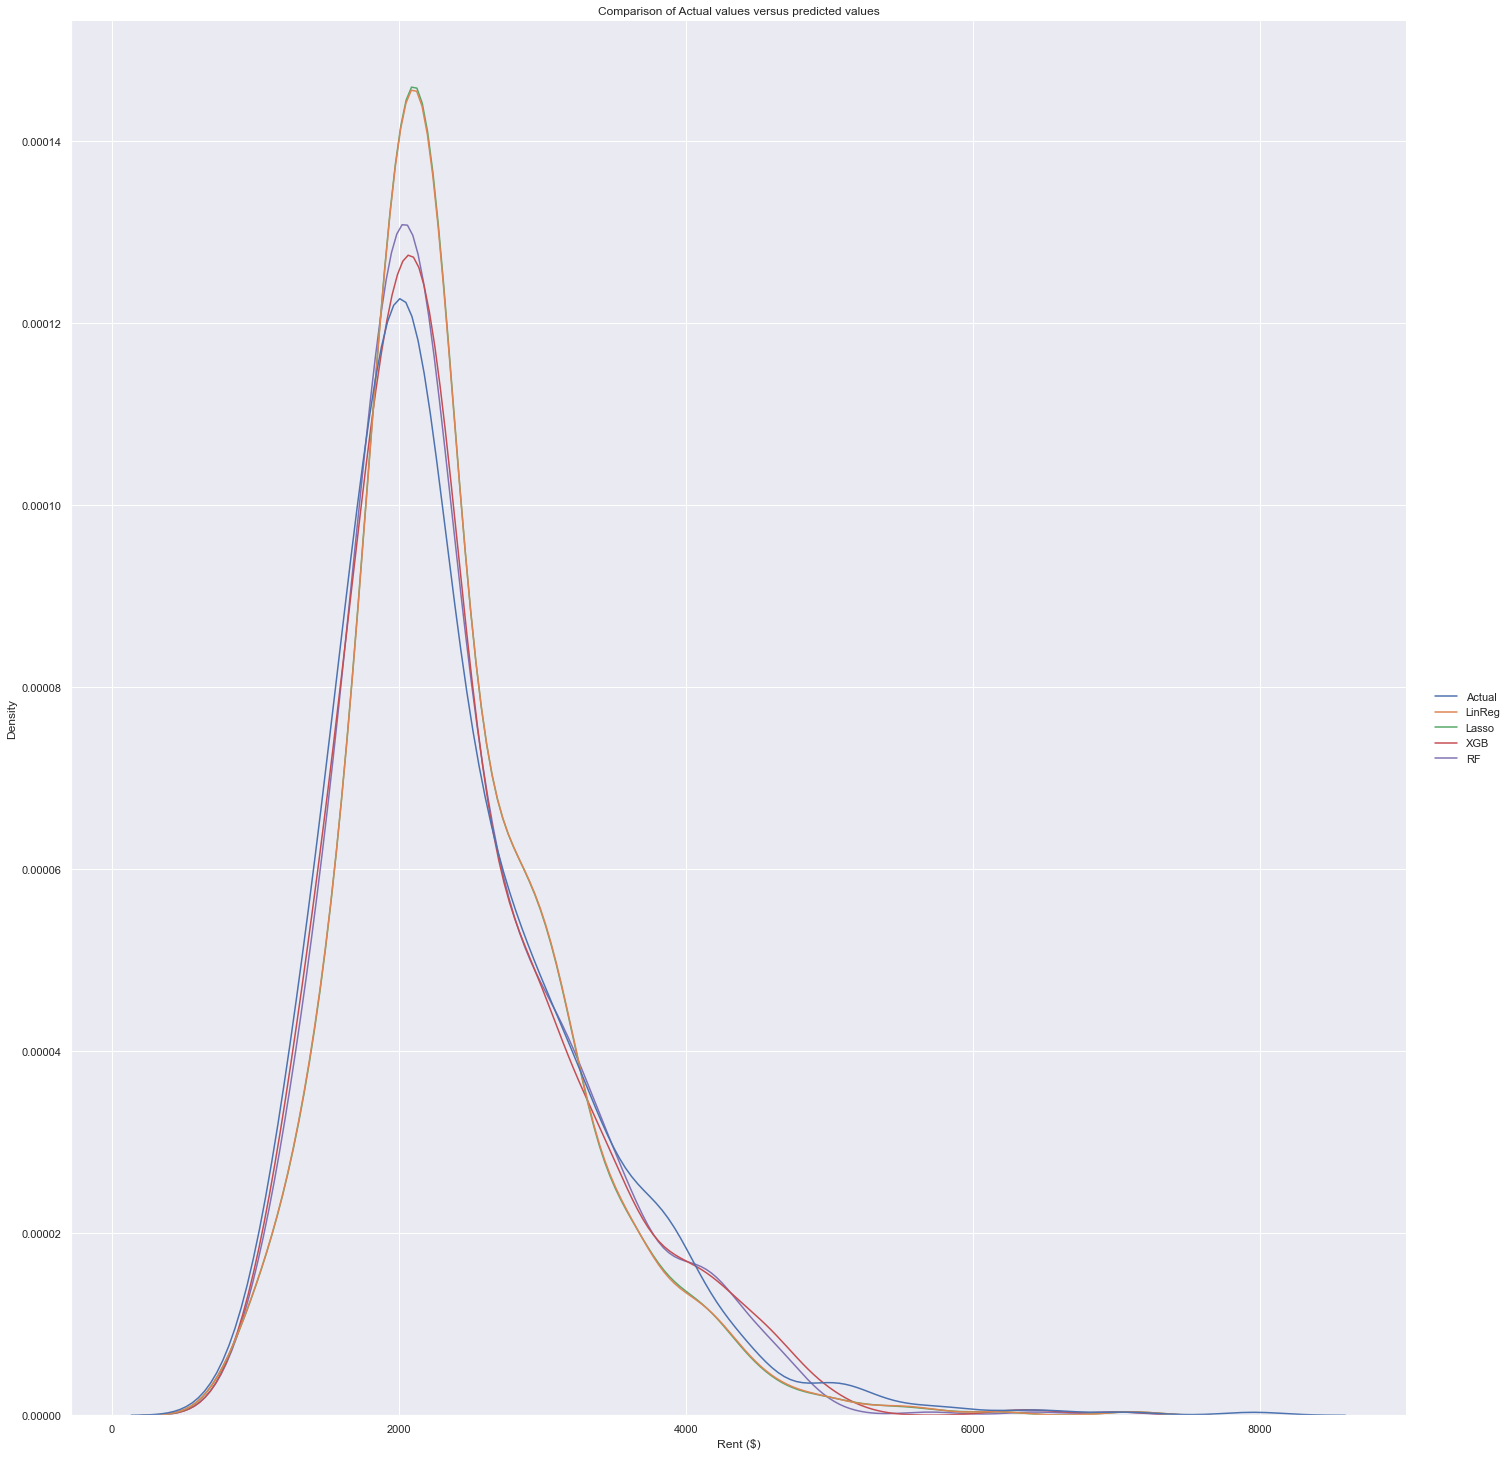

In [17]:
# Plot the results on a distribution 
plt.figure(figsize = (10,15))

ax = sns.displot(data = results_df, kind='kde', height = 20)
plt.title('Comparison of Actual values versus predicted values')
plt.xlabel('Rent ($)')
plt.show()

Both the XGB and Rand Forest models appear to be very similar. This was too be expected as this problem is well suited to tree based models. XGBoost has a slight edge in overall peformance so we will look at tuning the hyperparameters next. Focus will need to be placed on generalizing the model performance as it's definitely overfitting the data currently.

### Actual versus Predicted

/var/folders/1v/2xtr296s1rz_4kd_c4kx7qh00000gn/T/ipykernel_22818/1231161619.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m-" (-> color='m'). The keyword argument will take precedence.
  plb.plot(np.exp(xgb.predict(X_test)), p(np.exp(xgb.predict(X_test))), 'm-', color='red')


Text(0, 0.5, 'Actual Values ($)')

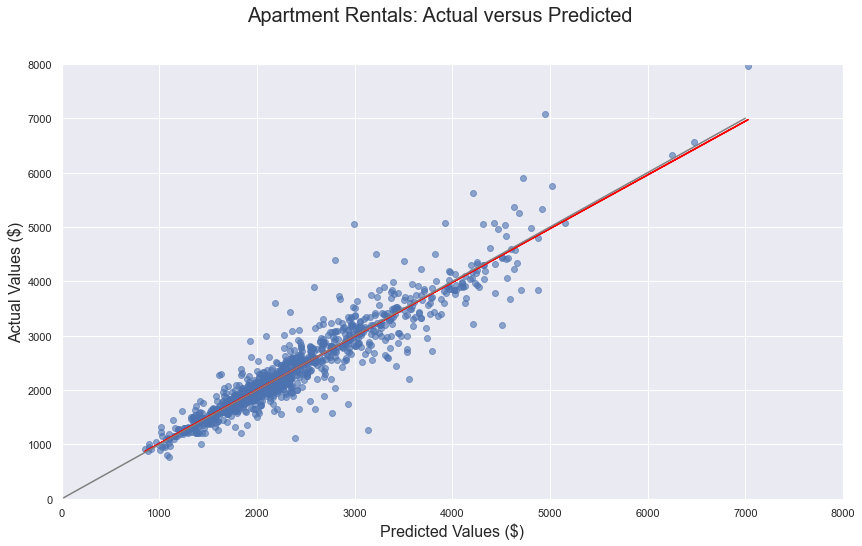

In [18]:
import matplotlib.pylab as plb 

plt.figure(figsize=(14, 8))
plt.scatter(np.exp(xgb.predict(X_test)), np.exp(y_test), alpha=.6) 

z = np.polyfit(np.exp(xgb.predict(X_test)), np.exp(y_test), 1)
p = np.poly1d(z)
plb.plot(np.exp(xgb.predict(X_test)), p(np.exp(xgb.predict(X_test))), 'm-', color='red')
plt.plot(np.linspace(0,7000,1000), np.linspace(0,7000,1000), color='grey')

plt.xlim(0, 8000)
plt.ylim(0, 8000)

plt.suptitle('Apartment Rentals: Actual versus Predicted', fontsize=20, fontname='Arial')
plt.xlabel('Predicted Values ($)', fontsize=16, fontname='Arial')
plt.ylabel('Actual Values ($)', fontsize=16, fontname='Arial')

Text(0, 0.5, 'Residuals ($)')

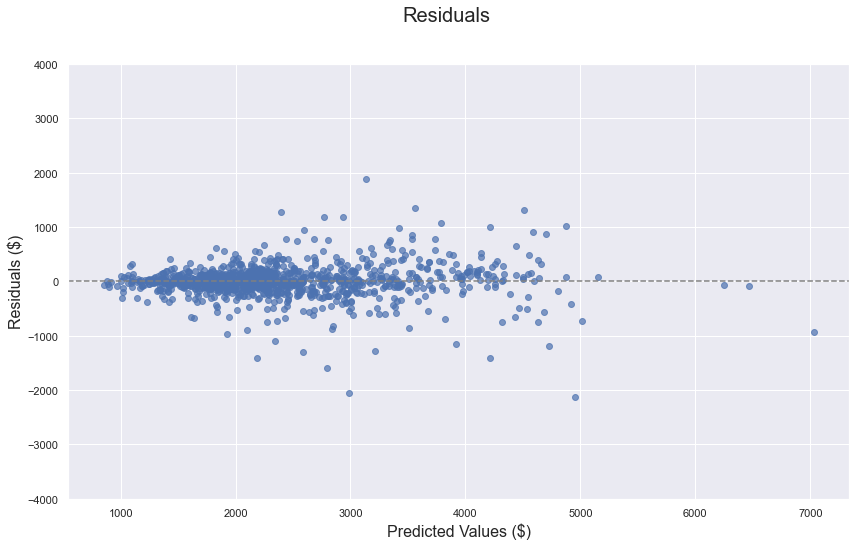

In [19]:
# Plot the residuals with respect to the predicted price

plt.figure(figsize=(14, 8))
plt.scatter((np.exp(xgb.predict(X_test))), (np.exp(xgb.predict(X_test)))-np.exp(y_test), alpha=.7)   

plt.axhline(0, linestyle='--', color='grey')
plt.suptitle('Residuals', fontsize=20, fontname='Arial')
plt.ylim(-4000, 4000)
plt.xlabel('Predicted Values ($)', fontsize=16, fontname='Arial')
plt.ylabel('Residuals ($)', fontsize=16, fontname='Arial')

## Evaluate the Feature Importances

In [20]:
# Extracting feature importances from the randomForest model
feature_importances = ({'Name':[],
                        'Score':[]})

for name, score in zip(X.columns, xgb.feature_importances_):
  feature_importances['Name'].append(name)
  feature_importances['Score'].append(score)

feature_importances = pd.DataFrame(feature_importances).sort_values(['Score'], ascending = False)

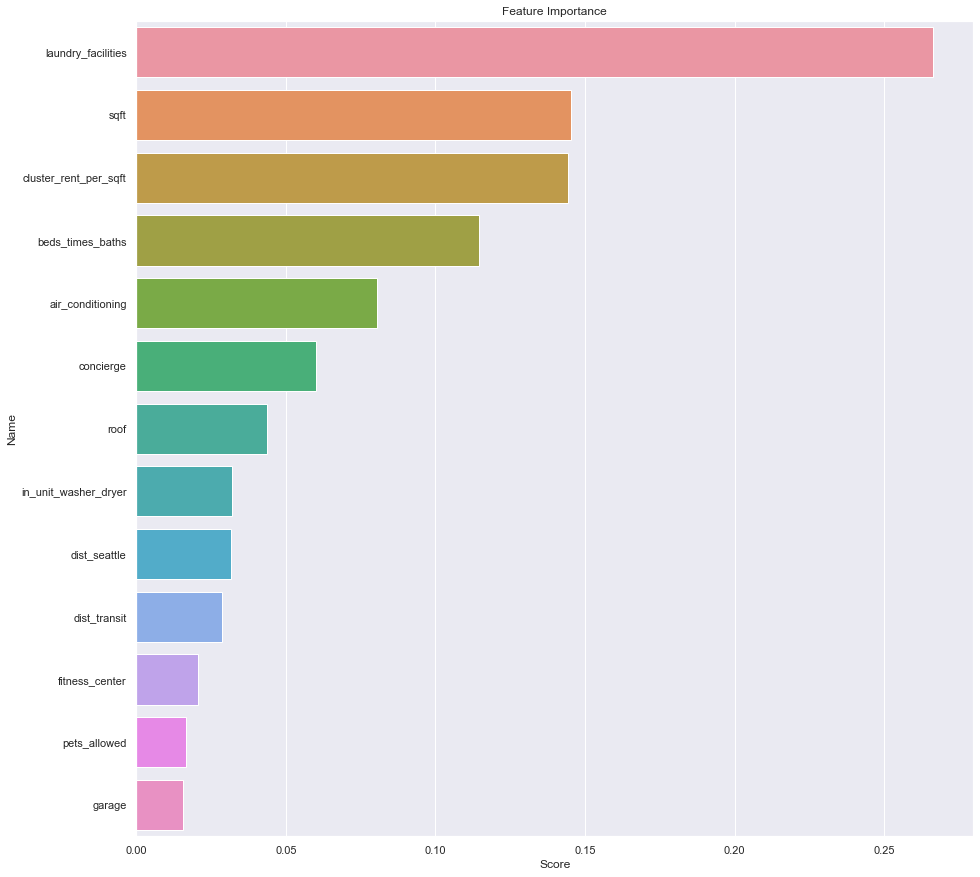

In [21]:
# Plot the feature importances
fig = plt.figure(figsize=(15,15))
sns.barplot(x = 'Score', y = 'Name', data = feature_importances)
plt.title('Feature Importance')
plt.show()

## Hyperparameter Tuning for XGBoost

In [22]:
params = {"learning_rate": [0.01, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7 , 1],
 "max_depth": np.arange(4,16,2),
 "min_child_weight": np.arange(1,15,1),
 "reg_alpha": np.arange(0,1,0.1),
 "n_estimators": np.arange(100,1000,100),
 "gamma": [0, 0.01, 0.05, 0.07, 0.1, 0.3, 0.7, 1],
 'colsample_bytree':[0, 0.4, 0.8, 1]
 }

In [23]:
regressor=XGBRegressor()

In [24]:
search = RandomizedSearchCV(estimator = regressor, 
                               param_distributions = params, 
                               n_iter = 50, cv = 3, n_jobs=1,
                               return_train_score=True, verbose = 2)  

In [25]:
# search.fit(X_train,y_train)

In [26]:
# best_params=search.best_params_
# best_params

best_params = {'reg_alpha': 0.30000000000000004,
 'n_estimators': 400,
 'min_child_weight': 12,
 'max_depth': 10,
 'learning_rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 0.4}

In [27]:
xgb=XGBRegressor(max_depth = best_params['max_depth'],
                 n_estimators = best_params['n_estimators'],
                 min_child_weight = best_params['min_child_weight'],
                 gamma = best_params['gamma'],
                 colsample_bytree = best_params['colsample_bytree'],
                 learning_rate = best_params['learning_rate'],
                 reg_alpha = best_params['reg_alpha']
                 )

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=12, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.30000000000000004, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [28]:
# Training data
pred_train = xgb.predict(X_train)
r2_train = r2_score(np.exp(y_train), np.exp(pred_train))
mse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(pred_train)))

# Test data
pred_test = xgb.predict(X_test)
r2_test = r2_score(np.exp(y_test), np.exp(pred_test))
mse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred_test)))

# Print results
print('R squared training set', round(r2_train,2))
print('R squared test set', round(r2_test,2))
print('RMSE training set', round(mse_train, 2))
print('RMSE test set', round(mse_test, 2))

R squared training set 0.95
R squared test set 0.89
RMSE training set 195.25
RMSE test set 283.37


In [29]:
# Export the model for future use

with open('./models/seattle_rent_prediction.pickle', 'wb') as handle:
    pkl.dump(xgb, handle)

In [30]:
X.columns

Index(['sqft', 'fitness_center', 'air_conditioning', 'in_unit_washer_dryer',
       'laundry_facilities', 'roof', 'concierge', 'garage', 'dist_seattle',
       'dist_transit', 'cluster_rent_per_sqft', 'beds_times_baths',
       'pets_allowed'],
      dtype='object')